<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# _*Quantum Awesomeness*_

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

***
### Contributors
James R. Wootton, IBM Research
***

To have a functioning quantum computer, you need more than just lots of qubits. For powerful algorithms we need information to be constantly moved around a device. This is always easiest for pairs of qubits that can directly talk to each other by a controlled operation. The connectivity of these operations is therefore another very important factor determining what a device can do. Another is the probability of errors. Unless this is sufficiently low, any results you'll get out will just be random noise.

So let's make a game that shows all these things directly. By just playing the game with a certain quantum device, the player will see exactly how big and connected the device is. By comparing a run on the real device with one on a simulator, they'll see exactly how potent the noise is. Then by playing again with some error mitigation, they'll get an idea of how much useful information can be salvaged even in the era of slightly noisy quantum computers.

This is the idea behind the game [Quantum Awesomeness](https://github.com/decodoku/A_Game_to_Benchmark_Quantum_Computers/blob/master/README.md). In this notebook we'll make a version designed specifically for Qiskit.

### Getting set up

You can play this game on any IBM device. Here we'll do it with `'ibmq_16_melbourne'`.

In [1]:
device = 'ibmq_16_melbourne'

To use this device, and to get information about it, we need to set up a Qiskit backend object for it.

In [2]:
from qiskit import IBMQ
IBMQ.load_accounts()
backend = IBMQ.get_backend(device)

To set up the game, we first need to know how many qubits the device has. We also need the list of which qubits can directly talk to which others. This information can be extracted directly from the backend.

In [3]:
num = backend.configuration()['n_qubits']
coupling_map = backend.configuration()['coupling_map']
print('number of qubits\n',num,'\n')
print('list of pairs of qubits that are directly connected\n',coupling_map)

number of qubits
 14 

list of pairs of qubits that are directly connected
 [[1, 0], [1, 2], [2, 3], [4, 3], [4, 10], [5, 4], [5, 6], [5, 9], [6, 8], [7, 8], [9, 8], [9, 10], [11, 3], [11, 10], [11, 12], [12, 2], [13, 1], [13, 12]]


During the game, images will be plotted to represent the device. For this we'll need to know where the qubits are located in relation to each other. This information can be found in human-readable form in the [device information repository](https://github.com/Qiskit/ibmq-device-information). We'll recreate it here in machine-readable form.

In [4]:
if device in ['ibmqx2','ibmqx4']:
    pos = { 0: (1,1), 1: (1,0), 2: (0.5,0.5), 3: (0,0), 4: (0,1) }        
elif device in ['ibmqx5']:
    pos = { 0: (0,0), 1: (0,1),  2: (1,1),  3: (2,1),  4: (3,1),  5: (4,1),  6: (5,1),  7: (6,1),
                8: (7,1), 9: (7,0), 10: (6,0), 11: (5,0), 12: (4,0), 13: (3,0), 14: (2,0), 15: (1,0) }
elif device in ['ibmq_16_melbourne']:
    pos = { 0: (0,1), 1: (1,1),  2: (2,1),  3: (3,1),  4: (4,1),  5: (5,1),  6: (6,1),
                7: (7,0), 8: (6,0), 9: (5,0), 10: (4,0), 11: (3,0), 12: (2,0), 13: (1,0) }

Now we have enough information to plot the device. For this we'll use classical tools, such as `networkx`. Since our focus here is to explain the quantum programming in the game, we'll just import and use these classical tools from the *game_engines* folder.

In [5]:
import sys
sys.path.append('game_engines')
from universal import layout

Let's take a first glimpse at our qubits.

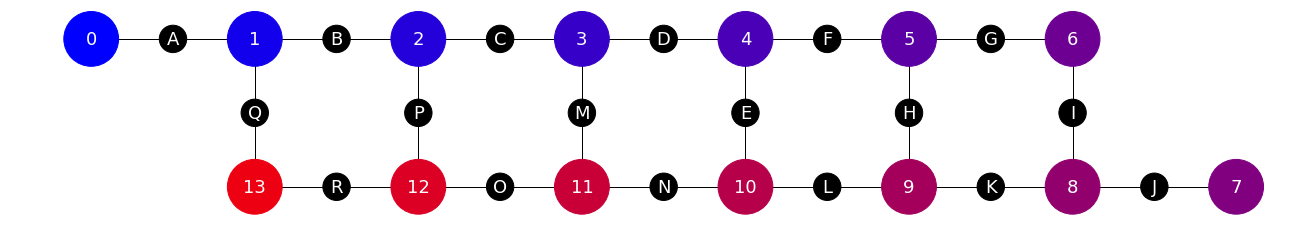

In [6]:
grid = layout(num,coupling_map,pos)
grid.plot()

Here each qubit is shown as a coloured circle, labelled with the numbers that are used to address them in programs. For example, if we do a `x` gate on qubit $7$, it is the one on the right that will have its state flipped between $|0\rangle$ and $|1\rangle$.

The lines connect pairs of qubits for which it is possible to directly perform a two-qubit entangling operation (such as `cx`). The visualization tools have labelled them with letters that will be used by players of the game.

### The game

The most useful thing about controlled operations is that they can create and manipulate entanglement. Only with this can we explore the full space of possibilities that is open to our qubits, and hope to do things that are practically impossible for classical computers.

The simplest kind of entanglement involves just two qubits. It will cause each to yield outputs that are random, but with correlations between them. For example, consider following program on a couple of qubits.

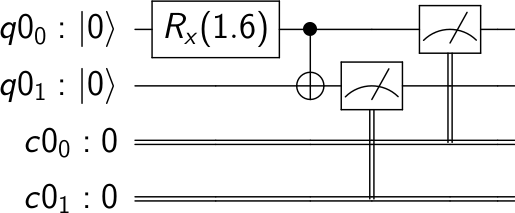

In [7]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import circuit_drawer
import numpy as np

qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qp = QuantumCircuit(qr,cr)

qp.rx( np.pi/2,qr[0])
qp.cx(qr[0],qr[1])

qp.measure(qr,cr)

circuit_drawer(qp)

Here we perform an `rx` operation by a the angle $\pi/2$, which results in what is essentially half an `x` gate. The effect on qubit $0$ is to turn the initial $|0\rangle$ state into an equal superposition of $|0\rangle$ and $|1\rangle$. The `cx` then applies an `x` to qubit $1$ only when qubit $0$ is in state $|1\rangle$. This therefore spreads the superposition to this qubit, resulting in them being in a combined superposition of both $|0\rangle$, and both $|0\rangle$. Each will give a random `0` or `1` as an output, but they will always agree with each other.

To verify this, let's run it.

In [8]:
from qiskit import execute
from qiskit import Aer
job = execute(qp,backend=Aer.get_backend('qasm_simulator'))
results = job.result().get_counts()
print(results)

{'11': 503, '00': 521}


Out of the 1024 samples that the program was run for, all results came out either `00` or `11`. And we have approximately equal numbers of samples for each. All as predicted.

By replacing the value of $\pi/2$ we can change the nature of the superposition. A lower value will produce results more biased to outputs of `0`, and a value closer to $\pi$ will result in a bias towards `1`s. This means we can vary the probability with which each output will give a `1`. But whatever value we choose, this form of circuit ensures that the results for the two qubits will always agree.

In this game we will make lots of these pairs of entangled qubits across the device. To do this, we must first choose a way to pair up the qubits monogamously. This pairing will be chosen randomly, and the whole point of the game is for the player to guess what the pairing was.

Again, we won't look into the details of this method because it is purely classical. We'll just run it and get our random pairs.

In [9]:
pairs = grid.matching()
print(pairs)

[[0, 1], [10, 4], [2, 3], [8, 7], [9, 5], [11, 12]]


As you may notice, not every qubit is always involved in one of these pairs. A pairing that fully covers the grid is not possible in some cames. The 5 qubit devices are obvious examples, because they have an odd number of qubits. For the _melbourne_ device it is less obvious, but the exact form of the `coupling_map` does not allow solutions where every qubit is paired. So that's something for players to watch out for.

But before players can do anything, we need to implement the game on the quantum computer. To do this we run through all of these pairs and implement the process shown in the circuit above. For each pair we'll choose a different value for the `rx` operation, so the degree of randomness shared by paired qubits will differ from pair to pair.

In [10]:
import random

qr = QuantumRegister(num)
cr = ClassicalRegister(num)
qp = QuantumCircuit(qr,cr)

for pair in pairs:
    qp.ry( (1+2*random.random())*np.pi/4,qr[pair[0]]) # angle generated randonly between pi/4 and 3pi/4
    qp.cx(qr[pair[0]],qr[pair[1]])
    
qp.measure(qr,cr)

Now we'll run the circuit and get results using a simulator. This is done over the standard number of samples (`shots=1024`) so that we can do statistics.

In [11]:
from qiskit import execute
job = execute(qp,backend=IBMQ.get_backend('ibmq_qasm_simulator'))
results = job.result().get_counts()

The only aspects of the result that we really want to see are
* What is the probability of each qubit giving an output of `1` instead of `0`?
* What is the probability that each pair of connected qubits give the same value?

This just requires a bit of classical processing

In [12]:
probs = grid.calculate_probs(results)

Now we can display these probabilities on our image of the device.

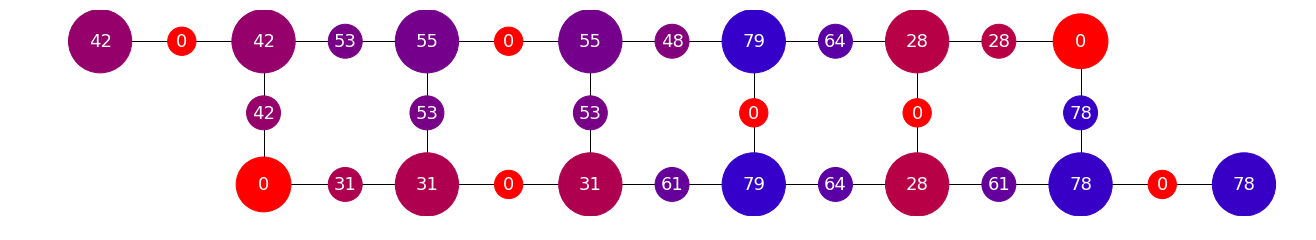

In [13]:
grid.plot(probs=probs)

Here the number displayed on each qubit is the percentage of samples for which the result was `1`. The number on each connection is the percentage of samples for which the corresponding pair of qubits had outcomes that disagreed.  With this information, we can easily find the pairs of qubits that were entangled: either by looking for the qubits that share the same probability of outputting a `1`, or finding the pairs that never disagreed.

Now let's run it on the real device.

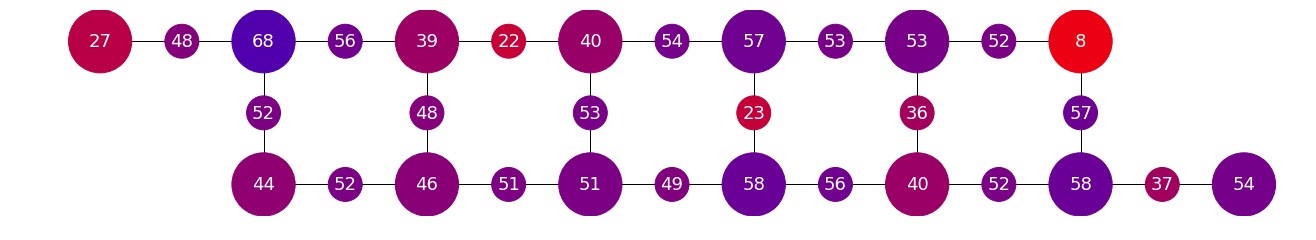

In [14]:
job = execute(qp,backend=backend)
results = job.result().get_counts()
probs = grid.calculate_probs(results)
grid.plot(probs=probs)

Here the results are not so clear as for the simulator. The effects of noise are much stronger, making it much harder to identify the pairs.

But all is not lost! We can do some error mitigation. We know that the output should have a certain structure, so we can search for that structure and use it to clean up the result.

Here's a very simplistic way to do that. First, each qubit will look at all its neighbours and see which one it agrees with most. It'll then assume that qubit is its partner. To try and balance out the errors in its results, we'll then replace the probability of getting an output of `1` for that qubit with the average from them both.

So we make a function to do the job.

In [16]:
def mitigate(probs):
    
    av_prob = {}
    for j in range(num): # for each qubit, work out which neighbour it agrees with most
        neighbours = []
        for pair in grid.links:
            if j in grid.links[pair]:
                neighbours.append(pair)
        (guessed_pair,val) = (None,1)
        for pair in neighbours:
            if probs[pair]<val:
                guessed_pair = pair
                val = probs[pair]
        # then find the average probability of a 1 for the two
        av_prob[j] = (probs[grid.links[guessed_pair][0]]+probs[grid.links[guessed_pair][1]])/2
    
    # replace the probabilities for all qubits with these averages
    for j in range(num):
        probs[j] = av_prob[j]
            
    return probs

Let's see what results we get.

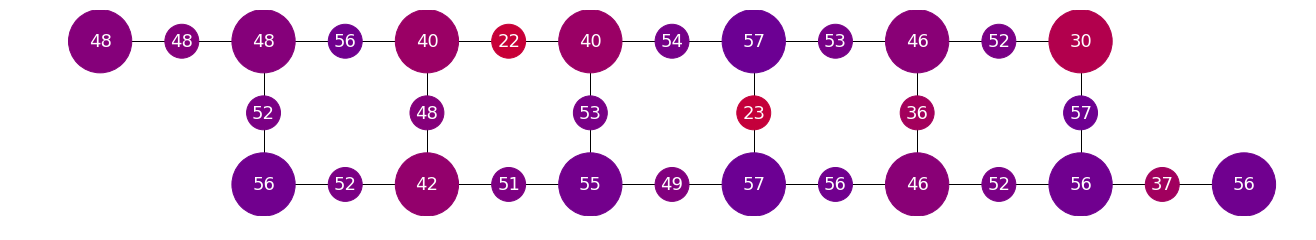

In [17]:
probs = mitigate(probs)
grid.plot(probs=probs)

This improves things, but it doesn't make them perfect by any means. Error mitigation can have powerful effects, but it is most effective when built into the quantum program itself. That's something you could try to experiment with if you'd like to expand upon this project.

For now, let's just play the game using these mitigated results. Look at the results and try to work out how they were paired. Obviously you'll have to forget that you've already seen the answer a few times already ;)


MOVE 1


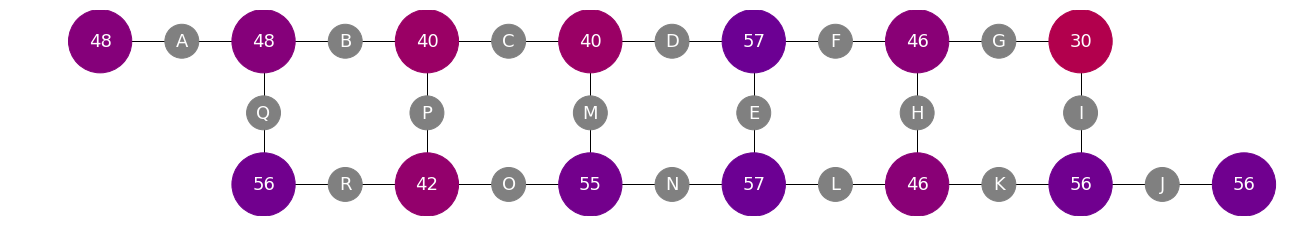

    > Type the name of a pair of qubits whose numbers are the same (or very similar)...
A

MOVE 2


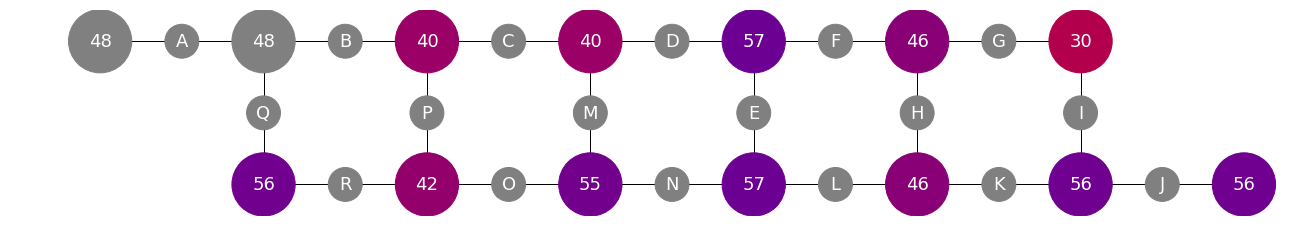

    > Type the name of a pair of qubits whose numbers are the same (or very similar)...
J

MOVE 3


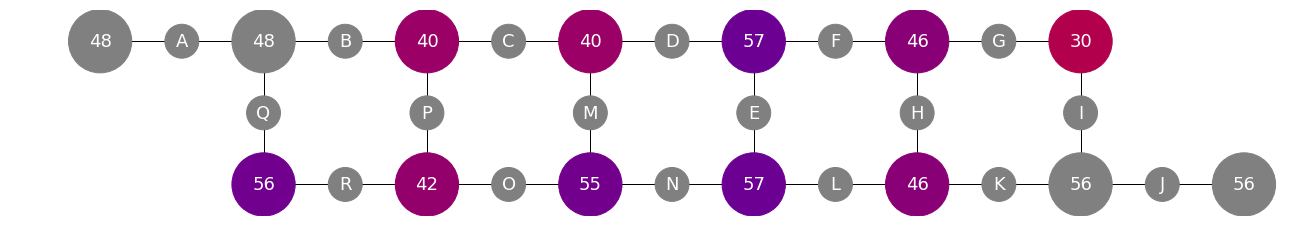

    > Type the name of a pair of qubits whose numbers are the same (or very similar)...
H

MOVE 4


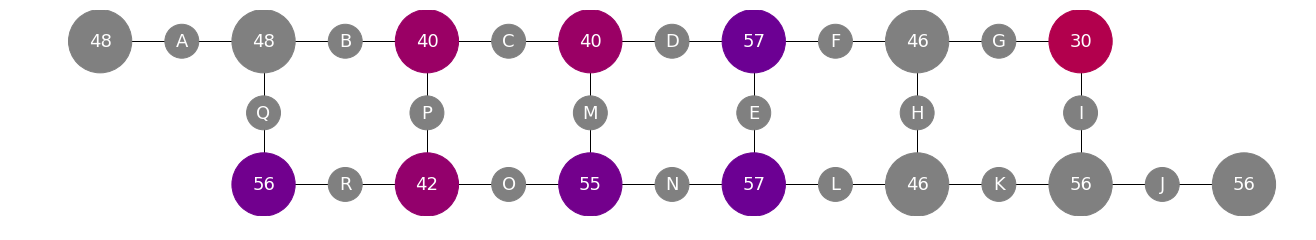

    > Type the name of a pair of qubits whose numbers are the same (or very similar)...
E

MOVE 5


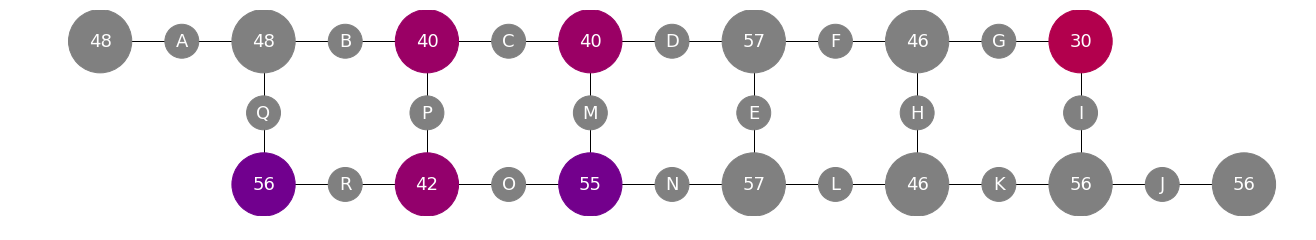

    > Type the name of a pair of qubits whose numbers are the same (or very similar)...
C

MOVE 6


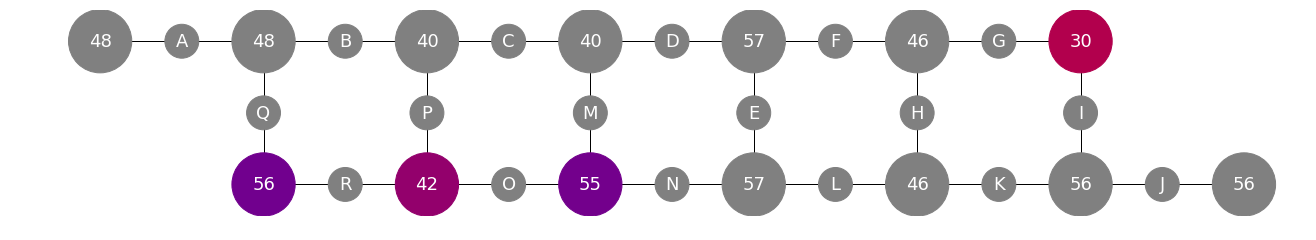

    > Type the name of a pair of qubits whose numbers are the same (or very similar)...
O


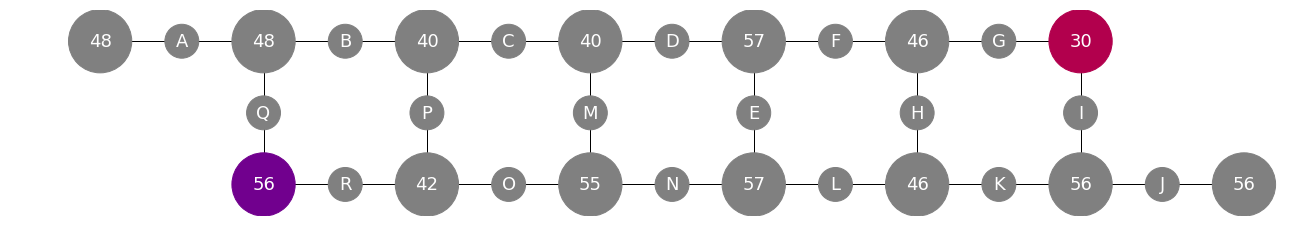

In [ ]:
pair_labels = {}
colors = {}
for node in grid.pos:
    if type(node)==str:
        pair_labels[node] = node
        colors[node] = (0.5,0.5,0.5)

chosen_pairs = []
m = 0
while len(chosen_pairs)<len(pairs):
    m += 1
    print('\nMOVE',m)
    grid.plot(probs=probs,labels=pair_labels,colors=colors)
    pair = str.upper(input("    > Type the name of a pair of qubits whose numbers are the same (or very similar)...\n"))
    chosen_pairs.append( pair )
    colors[pair] = (0.5,0.5,0.5)
    for j in range(2):
        colors[grid.links[pair][j]] = (0.5,0.5,0.5)

grid.plot(probs=probs,labels=pair_labels,colors=colors)

success = True
for pair in chosen_pairs:
    success = success and ( (grid.links[pair] in pairs) or (grid.links[pair][::-1] in pairs) )

if success:
    input("\n    ** You got all the correct pairs! :) **\n\n          Press any key to continue\n")
else:
    input("\n    ** You didn't get all the correct pairs! :( **\n\n          Press any key to continue\n")

### Expanding on this project

If you need some ideas for your first quantum project, why not have a go at contributing to this one. Here are some examples of things to do.

* You could write an algorithm to play the game. This would guess the pairs as correct as possible by cleverly analyzing the analyse the data.

* The puzzle is very easy to solve when there is no noise. How might you introduce different difficulty levels?

* The error mitigation used here is very simplistic. You could try to implement something more sophisticated, such as the 'robust phase estimation' described in [this talk](https://www.youtube.com/watch?v=YyfJ_OKkw_I).

* Could more complex entangled states, such as tripartite states, be used to ensure that no qubits on a device are left out of the fun?

* Using the `c_if` command, Qiskit allows for circuits with 'classical control'. This is essentional an `if` command inside a circuit, that allows us to do operations on one qubit that depend on the measurement results of others. Though current hardware doesn't support this functionality, it will become very important in future. Can you make a game that tests this ability too?

In [ ]:
keywords = {'Topics': ['Games', 'Hardware', 'Entanglement'], 'Commands': ['`rx`', '`cx`']}